In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os, sys, shutil
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import pickle
from scipy.stats import gaussian_kde
from statsmodels.tsa.stattools import acf

from windtools.amrwind.post_processing  import ABLStatistics, Sampling, addDatetime
from pyFAST.input_output import TurbSimFile, FASTOutputFile

sys.path.append(os.path.abspath('/home/rthedin/utilities/'))
from helper_fastfarm import readFFPlanes, readTurbineOutput, readTurbineOutputPar, readFFPlanesPar
from helper import interpolate_to_heights, addLabels, calc_QOIs

from samwich.dataloaders import XarrayData
from samwich.waketrackers import track, WakeTracker

In [3]:
matplotlib.rcParams.update({'font.size': 14})

# Process LES

In [4]:
# OpenFAST output is saved at a high time step, sometimes 0.005 s. It is too much to read it all, so we will only get some the time steps saved
dt_openfast   = 0.005
dt_processing = 0.1

# Time slice
timeslice = slice(600, None)

In [8]:
# old small unstable
LESpath = ['/projects/car/rthedin/amr_runs/04_2turbine_coherencestudy/01_2turbine_stable.W.8at150.20dTinv_0.25cooling_0.1z0_450zi_3.84x1.28x0.9km_res2.5m_coriolis5days_2ref',
           '/projects/car/rthedin/amr_runs/04_2turbine_coherencestudy/02_2turbine_neutral_8at150.10dTInv_0.75z0_750zi_3.84x1.28x0.9km_res2.5m_2ref',
           '/projects/car/rthedin/amr_runs/04_2turbine_coherencestudy/03_2turbine_unstable.W.8at150.20dTinv_0.05q_0.75z0_850zi_3.84x1.28x0.9km_res2.5m_2ref']

# old small unstable
precpath = ['/projects/car/rthedin/amr_runs/02_precursor_shell/stable.W.8at150.20dTinv_0.25cooling_0.1z0_450zi_3.84x1.28x0.9km_res2.5m_coriolis5days',
            '/projects/car/rthedin/amr_runs/02_precursor_shell/neutral_8at150.10dTInv_0.75z0_750zi_3.84x1.28x0.9km_res2.5m',
            '/projects/car/rthedin/amr_runs/02_precursor_shell/unstable.W.8at150.20dTinv_0.05q_0.75z0_850zi_3.84x1.28x0.9km_res2.5m']

# new larger unstable
precpath = ['/projects/car/rthedin/amr_runs/02_precursor_shell/stable.W.8at150.20dTinv_0.25cooling_0.1z0_450zi_3.84x1.28x0.9km_res2.5m_coriolis5days',
            '/projects/car/rthedin/amr_runs/02_precursor_shell/neutral_8at150.10dTInv_0.75z0_750zi_3.84x1.28x0.9km_res2.5m',
            '/projects/car/rthedin/amr_runs/02_precursor_shell/unstable.W.8at150.20dTinv_0.05q_0.75z0_850zi_10.24x5.12x0.96km_res5m']

## Open and process data for SAMWICH (from turbine simulation)

In [6]:
t1pathst = os.path.join(LESpath[0],'post_processing',f'planesT1121692.nc')
t2pathst = os.path.join(LESpath[0],'post_processing',f'planesT2121692.nc')
znpathst = os.path.join(LESpath[0],'post_processing',f'samplingxy121692.nc')
ynpathst = os.path.join(LESpath[0],'post_processing',f'samplingxz121692.nc')

t1pathne = os.path.join(LESpath[1],'post_processing',f'planesT1129921.nc')
t2pathne = os.path.join(LESpath[1],'post_processing',f'planesT2129921.nc')
znpathne = os.path.join(LESpath[1],'post_processing',f'samplingxy129921.nc')
ynpathne = os.path.join(LESpath[1],'post_processing',f'samplingxz129921.nc')

t1pathun = os.path.join(LESpath[2],'post_processing',f'planesT176826.nc')
t2pathun = os.path.join(LESpath[2],'post_processing',f'planesT276826.nc')
znpathun = os.path.join(LESpath[2],'post_processing',f'samplingxy76826.nc')
ynpathun = os.path.join(LESpath[2],'post_processing',f'samplingxz76826.nc')

outputPathst = os.path.join(LESpath[0],'processedData')
outputPathne = os.path.join(LESpath[1],'processedData')
outputPathun = os.path.join(LESpath[2],'processedData')
if not os.path.exists(outputPathst): os.makedirs(outputPathst)
if not os.path.exists(outputPathne): os.makedirs(outputPathne)
if not os.path.exists(outputPathun): os.makedirs(outputPathun)

In [7]:
# Read or process the planar data
if os.path.isdir(os.path.join(outputPathst, 'ds_t2_tempForSamwich.zarr')):
    # Data already processed. Reading output
    ds_t1_st = xr.open_zarr(os.path.join(outputPathst,'ds_t1_tempForSamwich.zarr'))
    ds_t2_st = xr.open_zarr(os.path.join(outputPathst,'ds_t2_tempForSamwich.zarr'))
    ds_zn_st = xr.open_zarr(os.path.join(outputPathst,'ds_znormal.zarr'))
    ds_yn_st = xr.open_zarr(os.path.join(outputPathst,'ds_ynormal.zarr'))
    
else:
    # Read, process planes, and sve temporary files so we can open them in samwich
    s1st = Sampling(t1pathst)
    s2st = Sampling(t2pathst)
    znst = Sampling(znpathst)
    ynst = Sampling(ynpathst)

    ds_t1_st = s1st.read_single_group('pT1',     simCompleted=True, outputPath = os.path.join(outputPathst,'ds_t1_tempForSamwich.zarr'));   del ds_t1_st
    ds_t2_st = s2st.read_single_group('pT2',     simCompleted=True, outputPath = os.path.join(outputPathst,'ds_t2_tempForSamwich.zarr'));   del ds_t2_st
    ds_zn_st = znst.read_single_group('xyplane', simCompleted=True, outputPath = os.path.join(outputPathst,'ds_znormal.zarr'));             del ds_zn_st
    ds_yn_st = ynst.read_single_group('xzplane', simCompleted=True, outputPath = os.path.join(outputPathst,'ds_ynormal.zarr'));             del ds_yn_st


In [8]:
# Read or process the planar data
if os.path.isdir(os.path.join(outputPathne, 'ds_t2_tempForSamwich.zarr')):
    # Data already processed. Reading output
    ds_t1_ne = xr.open_zarr(os.path.join(outputPathne,'ds_t1_tempForSamwich.zarr'))
    ds_t2_ne = xr.open_zarr(os.path.join(outputPathne,'ds_t2_tempForSamwich.zarr'))
    ds_zn_ne = xr.open_zarr(os.path.join(outputPathne,'ds_znormal.zarr'))
    ds_yn_ne = xr.open_zarr(os.path.join(outputPathne,'ds_ynormal.zarr'))
    
else:
    # Read, process planes, and sve temporary files so we can open them in samwich
    s1ne = Sampling(t1pathne)
    s2ne = Sampling(t2pathne)
    znne = Sampling(znpathne)
    ynne = Sampling(ynpathne)

    ds_t1_ne = s1ne.read_single_group('pT1',     simCompleted=True, outputPath = os.path.join(outputPathne,'ds_t1_tempForSamwich.zarr'));   del ds_t1_ne
    ds_t2_ne = s2ne.read_single_group('pT2',     simCompleted=True, outputPath = os.path.join(outputPathne,'ds_t2_tempForSamwich.zarr'));   del ds_t2_ne
    ds_zn_ne = znne.read_single_group('xyplane', simCompleted=True, outputPath = os.path.join(outputPathne,'ds_znormal.zarr'));             del ds_zn_ne
    ds_yn_ne = ynne.read_single_group('xzplane', simCompleted=True, outputPath = os.path.join(outputPathne,'ds_ynormal.zarr'));             del ds_yn_ne


In [9]:
# Read or process the planar data
if os.path.isdir(os.path.join(outputPathun, 'ds_t2_tempForSamwich.zarr')):
    # Data already processed. Reading output
    ds_t1_un = xr.open_zarr(os.path.join(outputPathun,'ds_t1_tempForSamwich.zarr'))
    ds_t2_un = xr.open_zarr(os.path.join(outputPathun,'ds_t2_tempForSamwich.zarr'))
    ds_zn_un = xr.open_zarr(os.path.join(outputPathun,'ds_znormal.zarr'))
    ds_yn_un = xr.open_zarr(os.path.join(outputPathun,'ds_ynormal.zarr'))
    
else:
    # Read, process planes, and sve temporary files so we can open them in samwich
    s1un = Sampling(t1pathun)
    s2un = Sampling(t2pathun)
    znun = Sampling(znpathun)
    ynun = Sampling(ynpathun)

    ds_t1_un = s1un.read_single_group('pT1',     simCompleted=True, outputPath = os.path.join(outputPathun,'ds_t1_tempForSamwich.zarr'));   del ds_t1_un
    ds_t2_un = s2un.read_single_group('pT2',     simCompleted=True, outputPath = os.path.join(outputPathun,'ds_t2_tempForSamwich.zarr'));   del ds_t2_un
    ds_zn_un = znun.read_single_group('xyplane', simCompleted=True, outputPath = os.path.join(outputPathun,'ds_znormal.zarr'));             del ds_zn_un
    ds_yn_un = ynun.read_single_group('xzplane', simCompleted=True, outputPath = os.path.join(outputPathun,'ds_ynormal.zarr'));             del ds_yn_un


In [10]:
D = 240

## Get precursor time-ave profiles

In [11]:
# Get precursor time-avg profile

# Stable
ablstat_st = os.path.join(precpath[0],'post_processing',f'abl_statistics121692.nc')
abl_st = ABLStatistics(ablstat_st, mean_profiles=True)
df_st = abl_st.ds.to_dataframe()
calc_QOIs(df_st,code='amr')
ds_st = df_st.to_xarray()
# We need the profile at the same heights of the wake data
profileds_st = interpolate_to_heights(ds_st['hvelmag'].to_dataframe(), ds_t2_st.z.values, timedim='time').to_xarray().mean('time')
profile_st = profileds_st['hvelmag'].values
height_st  = profileds_st['height'].values


# Neutral
ablstat_ne = os.path.join(precpath[1],'post_processing',f'abl_statistics129921.nc')
abl_ne = ABLStatistics(ablstat_ne, mean_profiles=True)
df_ne = abl_ne.ds.to_dataframe()
calc_QOIs(df_ne,code='amr')
ds_ne = df_ne.to_xarray()
# We need the profile at the same heights of the wake data
profileds_ne = interpolate_to_heights(ds_ne['hvelmag'].to_dataframe(), ds_t2_ne.z.values, timedim='time').to_xarray().mean('time')
profile_ne = profileds_ne['hvelmag'].values
height_ne  = profileds_ne['height'].values

# Unstable
#ablstat_un = os.path.join(precpath[2],'post_processing',f'abl_statistics76826.nc')
ablstat_un = os.path.join(precpath[2],'post_processing',f'abl_statistics75000.nc')
abl_un = ABLStatistics(ablstat_un, mean_profiles=True)
df_un = abl_un.ds.to_dataframe()
calc_QOIs(df_un,code='amr')
ds_un = df_un.to_xarray()
# We need the profile at the same heights of the wake data
profileds_un = interpolate_to_heights(ds_un['hvelmag'].to_dataframe(), ds_t2_un.z.values, timedim='time').to_xarray().mean('time')
profile_un = profileds_un['hvelmag'].values
height_un  = profileds_un['height'].values

## Open precursor planar data

Processing done in notebooks present in `/projects/car/rthedin/amr_runs/02_precursor_shell`

In [9]:
# Stable
# dsx_ = xr.open_dataset(os.path.join(precpath[0], 'processedData', 'dsxnormal.nc'))
# dsy_ = xr.open_dataset(os.path.join(precpath[0], 'processedData', 'dsynormal.nc'))
# dsz_ = xr.open_dataset(os.path.join(precpath[0], 'processedData', 'dsznormal.nc'))
dsx_st = xr.open_dataset(os.path.join(precpath[0], 'processedData', 'dsxnormal_datetime_mean.nc'))
dsy_st = xr.open_dataset(os.path.join(precpath[0], 'processedData', 'dsynormal_datetime_mean.nc'))
dsz_st = xr.open_dataset(os.path.join(precpath[0], 'processedData', 'dsznormal_datetime_mean.nc'))


# Neutral
# dsx_ = xr.open_zarr(os.path.join(precpath[1], 'processedData', 'dsxnormal.zarr'))
# dsy_ = xr.open_zarr(os.path.join(precpath[1], 'processedData', 'dsynormal.zarr'))
# dsz_ = xr.open_zarr(os.path.join(precpath[1], 'processedData', 'dsznormal.zarr'))
dsx_ne = xr.open_zarr(os.path.join(precpath[1], 'processedData', 'dsxnormal_datetime_mean.zarr'))
dsy_ne = xr.open_zarr(os.path.join(precpath[1], 'processedData', 'dsynormal_datetime_mean.zarr'))
dsz_ne = xr.open_zarr(os.path.join(precpath[1], 'processedData', 'dsznormal_datetime_mean.zarr'))


# Unstable
# dsx_ = xr.open_zarr(os.path.join(precpath[2], 'processedData', 'dsxnormal.zarr'))
# dsy_ = xr.open_zarr(os.path.join(precpath[2], 'processedData', 'dsynormal.zarr'))
# dsz_ = xr.open_zarr(os.path.join(precpath[2], 'processedData', 'dsznormal.zarr'))

# old small unstable
# dsz_un = xr.open_dataset(os.path.join(precpath[2], 'processedData', 'dsznormal_datetime_mean.nc'))
# dsx_un = xr.open_zarr(os.path.join(precpath[2],    'processedData', 'dsxnormal_datetime_mean.zarr'))
# dsy_un = xr.open_dataset(os.path.join(precpath[2], 'processedData', 'dsynormal_datetime_mean.nc'))
# new larger unstalbe
dsx_un = xr.open_dataset(os.path.join(precpath[2], 'processedData', 'dsxnormal_datetime_mean.nc'))
dsy_un = xr.open_dataset(os.path.join(precpath[2], 'processedData', 'dsynormal_datetime_mean.nc'))
dsz_un = xr.open_mfdataset(os.path.join(precpath[2], 'processedData', 'dsznormal_datetime_mean_*.nc'))

## Calculate wake center

In [ ]:
# ----------------- OPEN zarr, INITIALIZE TRACKING OBJECT AND REMOVE SHEAR
# Stable
wakedata_t1_st = XarrayData(os.path.join(outputPathst,'ds_t1_tempForSamwich.zarr'),tvar='samplingtimestep')
wakedata_t2_st = XarrayData(os.path.join(outputPathst,'ds_t2_tempForSamwich.zarr'),tvar='samplingtimestep')

# Neutral
wakedata_t1_ne = XarrayData(os.path.join(outputPathne,'ds_t1_tempForSamwich.zarr'),tvar='samplingtimestep')
wakedata_t2_ne = XarrayData(os.path.join(outputPathne,'ds_t2_tempForSamwich.zarr'),tvar='samplingtimestep')

# Unstable
wakedata_t1_un = XarrayData(os.path.join(outputPathun,'ds_t1_tempForSamwich.zarr'),tvar='samplingtimestep')
wakedata_t2_un = XarrayData(os.path.join(outputPathun,'ds_t2_tempForSamwich.zarr'),tvar='samplingtimestep')

# ---------------------------------------- ASSEMBLE DICTIONARY FOR LOOPING
allwakedata = {
               'wakedata_t1_st':wakedata_t1_st,
               'wakedata_t2_st':wakedata_t2_st,
               'wakedata_t1_ne':wakedata_t1_ne,
               'wakedata_t2_ne':wakedata_t2_ne,
               'wakedata_t1_un':wakedata_t1_un,
               'wakedata_t2_un':wakedata_t2_un,
              }



In [12]:
# Read or process the planar data
if os.path.isfile(os.path.join(LESpath[1],'processedData','ds_wakecenter_les_caseall.nc')):
    # Data already processed. Reading output
    ds_wakecenter_les = xr.open_dataset(os.path.join(LESpath[1],'processedData','ds_wakecenter_les_caseall.nc'))
    
else:
    # Calculate wake position and save zarr
    
    cond_to_read  = ['st','ne','un']
    #cond_to_read = ['ne']
    turb_to_read = [1,2]
    loc_to_read  = [1,2,3,4,5,6]

    ds_allloc_allturb_allcond = []
    for cond in cond_to_read:
        
        if cond == 'st': profile = profile_st
        if cond == 'ne': profile = profile_ne
        if cond == 'un': profile = profile_un

        ds_allloc_allturb_onecond = []
        for t in turb_to_read:
            current_wakedata = allwakedata[f'wakedata_t{t}_{cond}']
            

            ds_allloc_oneturb_onecond = []
            for loc in loc_to_read:
                print(f'Calculating track of plane {loc}D of turbine {t} of the {cond} condition', end='\r')
                track_gaussian_s100 = track(current_wakedata.sliceI(loc-1), method='Gaussian', verbose=False, vert_range=(25,500))
                track_gaussian_s100.remove_shear(wind_profile = profile)
                yc_gaussian_s100, zc_gaussian_s100 = track_gaussian_s100.find_centers(umin=None, sigma=100)

                ds_oneloc_oneturb_onecond = xr.Dataset(
                    data_vars=dict(
                        yc = (['samplingtimestep', 'algorithm'],  yc_gaussian_s100.reshape(-1, 1)),
                        zc = (['samplingtimestep', 'algorithm'],  zc_gaussian_s100.reshape(-1, 1)),
                    ),
                    coords=dict(
                        samplingtimestep = np.arange(0,len(yc_gaussian_s100)),
                        algorithm = ['gauss_s100']
                    ),
                )             
                
                ds_oneloc_oneturb_onecond = ds_oneloc_oneturb_onecond.expand_dims('loc_in_D').assign_coords({'loc_in_D':[loc]})
                ds_allloc_oneturb_onecond.append(ds_oneloc_oneturb_onecond)
            ds_allloc_oneturb_onecond = xr.concat(ds_allloc_oneturb_onecond, dim='loc_in_D')

            ds_allloc_oneturb_onecond = ds_allloc_oneturb_onecond.expand_dims('turbine').assign_coords({'turbine': [t]})
            ds_allloc_allturb_onecond.append(ds_allloc_oneturb_onecond)
        ds_allloc_allturb_onecond = xr.concat(ds_allloc_allturb_onecond, dim='turbine')

        ds_allloc_allturb_onecond = ds_allloc_allturb_onecond.expand_dims('cond').assign_coords({'cond': [cond]})
        ds_allloc_allturb_allcond.append(ds_allloc_allturb_onecond)
    ds_allloc_allturb_allcond = xr.concat(ds_allloc_allturb_allcond, dim='cond')

    ds_wakecenter_les = ds_allloc_allturb_allcond.copy()

    ds_wakecenter_les.to_netcdf(os.path.join(LESpath[1],'processedData','ds_wakecenter_les_caseall.nc'))

In [13]:
def percentilegrad( time_series):

    # Set the lower and upper percentile thresholds
    lower_percentile = 0.5
    upper_percentile = 99.5

    # Calculate the lower and upper percentile values
    lower_threshold = np.percentile(time_series, lower_percentile)
    upper_threshold = np.percentile(time_series, upper_percentile)

   # Set the window size for the moving average
    window_size = 3

    # Define the convolution kernel
    kernel = np.ones(window_size) / window_size

    # Calculate the moving average using numpy.convolve
    rolling_mean = np.convolve(time_series, kernel, mode='same')


    # Set a threshold value for the difference between adjacent data points in the time series
    threshold = 10

    # Replace any data point that falls outside the percentile range or has a difference greater than the threshold with NaN
    time_series[(time_series < lower_threshold) | (time_series > upper_threshold) | (abs(time_series - rolling_mean) >= threshold)] = np.nan
    
    return time_series


def calc_adjusted_wakecenter_les(wakecenter_les):

    [i_, j_, k_] = np.shape(wakecenter_les.yc.values)
    
    yc_adj = np.zeros_like(wakecenter_les.yc.values)
    zc_adj = np.zeros_like(wakecenter_les.zc.values)

    for i in range(i_):
        for j in range(j_):
                yc_adj[i,j,:] = percentilegrad(wakecenter_les.yc.values[i,j,:])
                zc_adj[i,j,:] = percentilegrad(wakecenter_les.zc.values[i,j,:])

    wakecenter_les['yc_adj'] = (('turbine','loc_in_D','samplingtimestep'), yc_adj)
    wakecenter_les['zc_adj'] = (('turbine','loc_in_D','samplingtimestep'), zc_adj)

    return wakecenter_les

In [19]:
# from cell below. run for unstable/stable then delete and run the cell below which will just read the nc files
# Split the wake array for LES case
wakecenter_les_st = ds_wakecenter_les.sel(cond='st', algorithm='gauss_s100', samplingtimestep=timeslice)
wakecenter_les_un = ds_wakecenter_les.sel(cond='un', algorithm='gauss_s100', samplingtimestep=timeslice)

# Remove extreme values and high gradients from the wake center dataset
wakecenter_les_st = calc_adjusted_wakecenter_les(wakecenter_les_st)
wakecenter_les_un = calc_adjusted_wakecenter_les(wakecenter_les_un)

wakecenter_les_st.to_netcdf(os.path.join(LESpath[0], 'processedData', 'ds_wakecenter_les_st.nc'))
wakecenter_les_un.to_netcdf(os.path.join(LESpath[2], 'processedData', 'ds_wakecenter_les_un.nc'))

In [14]:
# Read or process the adjusted wake centers
if os.path.isfile(os.path.join(LESpath[2], 'processedData', 'ds_wakecenter_les_ne.nc')):
    # Data already processed. Reading output
    wakecenter_les_st = xr.open_dataset(os.path.join(LESpath[0], 'processedData', 'ds_wakecenter_les_st.nc'))
    wakecenter_les_ne = xr.open_dataset(os.path.join(LESpath[1], 'processedData', 'ds_wakecenter_les_ne.nc'))
    wakecenter_les_un = xr.open_dataset(os.path.join(LESpath[2], 'processedData', 'ds_wakecenter_les_un.nc'))
    
else:
    
    # Split the wake array for LES case
    wakecenter_les_st = ds_wakecenter_les.sel(cond='st', algorithm='gauss_s100', samplingtimestep=timeslice)
    wakecenter_les_ne = ds_wakecenter_les.sel(cond='ne', algorithm='gauss_s100', samplingtimestep=timeslice)
    wakecenter_les_un = ds_wakecenter_les.sel(cond='un', algorithm='gauss_s100', samplingtimestep=timeslice)

    # Remove extreme values and high gradients from the wake center dataset
    wakecenter_les_st = calc_adjusted_wakecenter_les(wakecenter_les_st)
    wakecenter_les_ne = calc_adjusted_wakecenter_les(wakecenter_les_ne)
    wakecenter_les_un = calc_adjusted_wakecenter_les(wakecenter_les_un)

    wakecenter_les_st.to_netcdf(os.path.join(LESpath[0], 'processedData', 'ds_wakecenter_les_st.nc'))
    wakecenter_les_ne.to_netcdf(os.path.join(LESpath[1], 'processedData', 'ds_wakecenter_les_ne.nc'))
    wakecenter_les_un.to_netcdf(os.path.join(LESpath[2], 'processedData', 'ds_wakecenter_les_un.nc'))

In [21]:
# Concatenate all 3 cases. This needs to be replaced. Right now, only the neutral is here. 

wakecenter_les = xr.concat([wakecenter_les_st, wakecenter_les_ne, wakecenter_les_un], dim="cond").assign_coords({'cond': ['st', 'ne', 'un']})
wakecenter_les.to_netcdf(os.path.join(LESpath[1], 'processedData',f'ds_wakecenter_les_all_dt1s.nc'))
#wakecenter_les = wakecenter_les_ne.expand_dims('cond').assign_coords({'cond':['ne']})
#wakecenter_les.to_netcdf(os.path.join(LESpath[1], 'processedData',f'ds_wakecenter_les_all_dt1s_TEMPneutralOnly.nc'))

## Read turbine data

In [15]:
def rename_vars_openfast(df):
    # Rename variables to get rid of problematic characters ('-','/')
    varlist = list(df.keys())
    varlistnew = [i.replace('/','_per_').replace('-','') for i in varlist]
    renameDict = dict(zip(varlist, varlistnew))
    if isinstance(df, xr.Dataset):
        newdf = df.rename_vars(renameDict)
    elif isinstance(df, pd.DataFrame):
        newdf = df.rename(columns=renameDict)
        # get rid of repeated entries
        newdf = newdf.loc[:,~newdf.columns.duplicated()].copy()
    
    return newdf


In [16]:
#casepath = '/projects/car/rthedin/amr_runs/03_5turbine_calibration_ff/01_5turbine_neutral.W.8.6at150.10dTInv.0.75z0.750zi_10x7x1k/turbine_iea15mw'
outfiles = ['IEA-15-240-RWT-Monopile.T1.out',
            'IEA-15-240-RWT-Monopile.T2.T1.out']

In [17]:
# Read all turbine output at the dt specified at the cell above and save a zarr file. Load file if present.
if os.path.isfile(os.path.join(LESpath[0], 'processedData',f'ds_turbineOutput_les_st_dt0.1s.nc')):
    # Processing already done. Load file
    turbsst = xr.open_dataset(os.path.join(LESpath[0], 'processedData',f'ds_turbineOutput_les_st_dt0.1s.nc'))
else:
    turbs_t = []
    for t, outf in enumerate(outfiles):
        print(f'Processing turbine {t+1}: {outf}')

        df   = FASTOutputFile(os.path.join(LESpath[0], 'turbine_iea15mw', outf)).toDataFrame()
        df   = rename_vars_openfast(df)
        ds_t = df.rename(columns={'Time_[s]':'time'}).set_index('time').to_xarray()
        ds_t = ds_t.isel(time=slice(0,None,int(dt_processing/dt_openfast))).sel(time=timeslice)
        ds_t = ds_t.expand_dims(['turbine']).assign_coords({'turbine': [t+1]})
        turbs_t.append(ds_t)

    turbsst = xr.concat(turbs_t,dim='turbine')

    turbsst.to_netcdf(os.path.join(LESpath[0], 'processedData',f'ds_turbineOutput_les_st_dt0.1s.nc'))

In [18]:
# Read all turbine output at the dt specified at the cell above and save a zarr file. Load file if present.
if os.path.isfile(os.path.join(LESpath[1], 'processedData',f'ds_turbineOutput_les_ne_dt0.1s.nc')):
    # Processing already done. Load file
    turbsne = xr.open_dataset(os.path.join(LESpath[1], 'processedData',f'ds_turbineOutput_les_ne_dt0.1s.nc'))
else:
    turbs_t = []
    for t, outf in enumerate(outfiles):
        print(f'Processing turbine {t+1}: {outf}')

        df   = FASTOutputFile(os.path.join(LESpath[1], 'turbine_iea15mw', outf)).toDataFrame()
        df   = rename_vars_openfast(df)
        ds_t = df.rename(columns={'Time_[s]':'time'}).set_index('time').to_xarray()
        ds_t = ds_t.isel(time=slice(0,None,int(dt_processing/dt_openfast))).sel(time=timeslice)
        ds_t = ds_t.expand_dims(['turbine']).assign_coords({'turbine': [t+1]})
        turbs_t.append(ds_t)

    turbsne = xr.concat(turbs_t,dim='turbine')

    turbsne.to_netcdf(os.path.join(LESpath[1], 'processedData',f'ds_turbineOutput_les_ne_dt0.1s.nc'))

In [19]:
# Read all turbine output at the dt specified at the cell above and save a zarr file. Load file if present.
if os.path.isfile(os.path.join(LESpath[2], 'processedData', f'ds_turbineOutput_les_un_dt0.1s.nc')):
    # Processing already done. Load file
    turbsun = xr.open_dataset(os.path.join(LESpath[2], 'processedData', f'ds_turbineOutput_les_un_dt0.1s.nc'))
else:
    turbs_t = []
    for t, outf in enumerate(outfiles):
        print(f'Processing turbine {t+1}: {outf}')

        df   = FASTOutputFile(os.path.join(LESpath[2], 'turbine_iea15mw', outf)).toDataFrame()
        df   = rename_vars_openfast(df)
        ds_t = df.rename(columns={'Time_[s]':'time'}).set_index('time').to_xarray()
        ds_t = ds_t.isel(time=slice(0,None,int(dt_processing/dt_openfast))).sel(time=timeslice)
        ds_t = ds_t.expand_dims(['turbine']).assign_coords({'turbine': [t+1]})
        turbs_t.append(ds_t)

    turbsun = xr.concat(turbs_t,dim='turbine')

    turbsun.to_netcdf(os.path.join(LESpath[2], 'processedData', f'ds_turbineOutput_les_un_dt0.1s.nc'))

In [34]:
# Concatenate all 3 cases. This needs to be replaced. Right now, only the neutral is here. 

turbs_les = xr.concat([turbsst, turbsne, turbsun], dim="cond").assign_coords({'cond': ['st', 'ne', 'un']})
#turbs_les = turbsne.expand_dims('cond').assign_coords({'cond':['ne']})
#turbs_les.to_netcdf(os.path.join(LESpath[1], 'processedData',f'ds_turbineOutput_les_all_dt0.1s_TEMPneutralOnly.nc'))

In [36]:
# Calculate additional quantities
turbs_les['calcCp'] = (turbs_les['RotPwr_[kW]']*1e3)/(0.5 * 1.225 * turbs_les['RtArea_[m^2]'] * 8.6**3)
turbs_les['calcCt'] = (turbs_les['RotThrust_[kN]']*1e3)/(0.5 * 1.225 * turbs_les['RtArea_[m^2]'] * 8.6**2)
turbs_les['hvel'] = (turbs_les['Wind1VelX_[m_per_s]']**2 + turbs_les['Wind1VelY_[m_per_s]']**2)**0.5

In [38]:
turbs_les.to_netcdf(os.path.join(LESpath[1], 'processedData',f'ds_turbineOutput_les_all_dt0.1s.nc'))

## Calculate length scale 

Based on high-frequency slices

In [10]:
lag_s = 120
dt = 0.5
lag_dt = int(lag_s/dt)  # in number of time steps

In [29]:
# Downselect fewer points for length scale computation.
array_st = dsz_st.sel(z=151.25)['up'].isel(x=slice(None,None,48), y=slice(None,None,4), datetime=slice(None,None,int(2*dt)))
array_ne = dsz_ne.sel(z=151.25)['up'].isel(x=slice(None,None,48), y=slice(None,None,4), datetime=slice(None,None,int(2*dt)))
# old small unstable
#array_un = dsz_un.sel(z=151.25)['up'].isel(x=slice(None,None,48), y=slice(None,None,4), datetime=slice(None,None,int(2*dt)))
# new larger unstable
array_un = dsz_un.sel(z=147.5)['up'].isel(x=slice(None,None,64), y=slice(None,None,8), datetime=slice(None,None,int(2*dt)))

In [33]:
acf_u_st = np.zeros((len(array_st.x.values), len(array_st.y.values), lag_dt+1))
for i,x in enumerate(array_st.x.values):
    for j,y in enumerate(array_st.y.values):
        print(f'Computing autocorrelation for x={x} and y={y}', end='\r')
        acf_u_st[i,j,:] =  acf(array_st.sel(x=x, y=y), nlags=lag_dt, fft=True)
        
        
ds_autocorr_st = xr.Dataset(data_vars=dict( acf_u=(['x','y','lag'], acf_u_st) ),
                    coords = {'x':array_st.x.values,
                              'y':array_st.y.values,
                              'lag':np.arange(0,lag_s+dt,dt)},
                   )

In [34]:
acf_u_ne = np.zeros((len(array_ne.x.values), len(array_ne.y.values), lag_dt+1))
for i,x in enumerate(array_ne.x.values):
    for j,y in enumerate(array_ne.y.values):
        print(f'Computing autocorrelation for x={x} and y={y}', end='\r')
        acf_u_ne[i,j,:] =  acf(array_ne.sel(x=x, y=y), nlags=lag_dt, fft=True)
        
        
ds_autocorr_ne = xr.Dataset(data_vars=dict( acf_u=(['x','y','lag'], acf_u_ne) ),
                    coords = {'x':array_ne.x.values,
                              'y':array_ne.y.values,
                              'lag':np.arange(0,lag_s+dt,dt)},
                   )

In [49]:
lag_s = 180
dt = 0.5
lag_dt = int(lag_s/dt)  # in number of time steps

acf_u_un = np.zeros((len(array_un.x.values), len(array_un.y.values), lag_dt+1))
for i,x in enumerate(array_un.x.values):
    for j,y in enumerate(array_un.y.values):
        print(f'Computing autocorrelation for x={x} and y={y}', end='\r')
        acf_u_un[i,j,:] =  acf(array_un.sel(x=x, y=y), nlags=lag_dt, fft=True)
        
        
ds_autocorr_un = xr.Dataset(data_vars=dict( acf_u=(['x','y','lag'], acf_u_un) ),
                    coords = {'x':array_un.x.values,
                              'y':array_un.y.values,
                              'lag':np.arange(0,lag_s+dt,dt)},
                   )

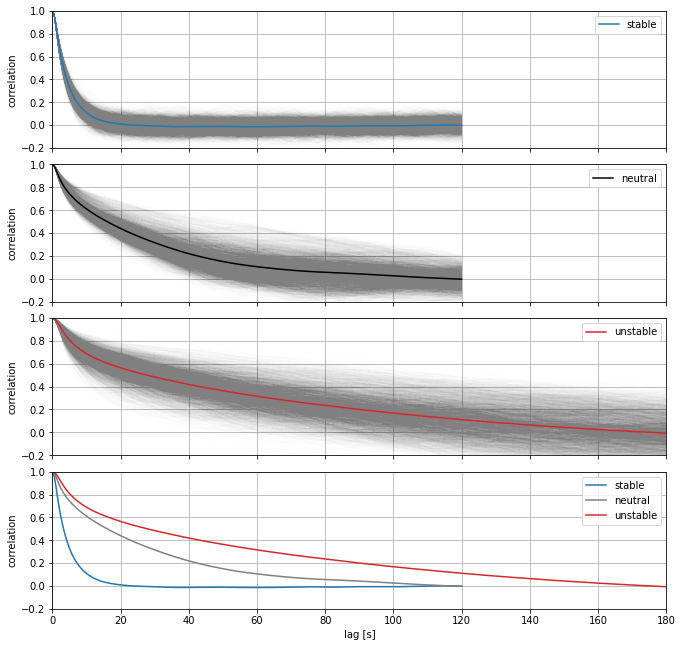

In [50]:
fig, axs = plt.subplots(4,1,figsize=(11,11), sharex=True, gridspec_kw={'hspace':0.12})

for x in ds_autocorr_st.x:
    for y in ds_autocorr_st.y:
        axs[0].plot(ds_autocorr_st['lag'], ds_autocorr_st.sel(x=x, y=y)['acf_u'], c='gray', alpha=0.002)
axs[0].plot(ds_autocorr_st['lag'], ds_autocorr_st.mean(dim=['x','y'])['acf_u'], c='tab:blue', label='stable')

for x in ds_autocorr_ne.x:
    for y in ds_autocorr_ne.y:
        axs[1].plot(ds_autocorr_ne['lag'], ds_autocorr_ne.sel(x=x, y=y)['acf_u'], c='gray', alpha=0.002)
axs[1].plot(ds_autocorr_ne['lag'], ds_autocorr_ne.mean(dim=['x','y'])['acf_u'], c='black', label='neutral')


for x in ds_autocorr_un.x:
    for y in ds_autocorr_un.y:
        axs[2].plot(ds_autocorr_un['lag'], ds_autocorr_un.sel(x=x, y=y)['acf_u'], c='gray', alpha=0.002)
axs[2].plot(ds_autocorr_un['lag'], ds_autocorr_un.mean(dim=['x','y'])['acf_u'], c='tab:red', label='unstable')


axs[3].plot(ds_autocorr_st['lag'], ds_autocorr_st.mean(dim=['x','y'])['acf_u'], c='tab:blue', label='stable')
axs[3].plot(ds_autocorr_ne['lag'], ds_autocorr_ne.mean(dim=['x','y'])['acf_u'], c='gray',     label='neutral')
axs[3].plot(ds_autocorr_un['lag'], ds_autocorr_un.mean(dim=['x','y'])['acf_u'], c='tab:red',  label='unstable')


axs[-1].set_xlabel('lag [s]')
for ax in axs:
    ax.set_ylim([-0.2,1])
    ax.set_xlim([0, lag_s])
    ax.set_ylabel('correlation')
    ax.legend()
    ax.grid()

In [55]:
# Get means on separate variables for convenience
acf_u_st_mean = ds_autocorr_st.mean(dim=['x','y'])['acf_u']
acf_u_ne_mean = ds_autocorr_ne.mean(dim=['x','y'])['acf_u']
acf_u_un_mean = ds_autocorr_un.mean(dim=['x','y'])['acf_u']


# get instant that crosses zero
pos0cross_st = np.argmax(acf_u_st_mean.values<0)
pos0cross_ne = np.argmax(acf_u_ne_mean.values<0)
pos0cross_un = np.argmax(acf_u_un_mean.values<0)
#pos0cross_un=241

Ltime_st = np.trapz(acf_u_st_mean[:pos0cross_st], acf_u_st_mean.lag[:pos0cross_st])
Ltime_ne = np.trapz(acf_u_ne_mean[:pos0cross_ne], acf_u_ne_mean.lag[:pos0cross_ne])
Ltime_un = np.trapz(acf_u_un_mean[:pos0cross_un], acf_u_un_mean.lag[:pos0cross_un])

L_st = Ltime_st*8
L_ne = Ltime_ne*8
L_un = Ltime_un*8

print(f'State    |  Time scale [s]  | Length scale [m] ')
print(f'-----------------------------------------------')
print(f'Stable   |       {Ltime_st:.2f}       |      {L_st:.2f}    ')
print(f'Neutral  |       {Ltime_ne:.2f}      |      {L_ne:.2f}    ')
print(f'Unstable |       {Ltime_un:.2f}      |      {L_un:.2f}    ')

State    |  Time scale [s]  | Length scale [m] 
-----------------------------------------------
Stable   |       4.61       |      36.87    
Neutral  |       24.92      |      199.39    
Unstable |       46.55      |      372.42    


### old using small unstable case

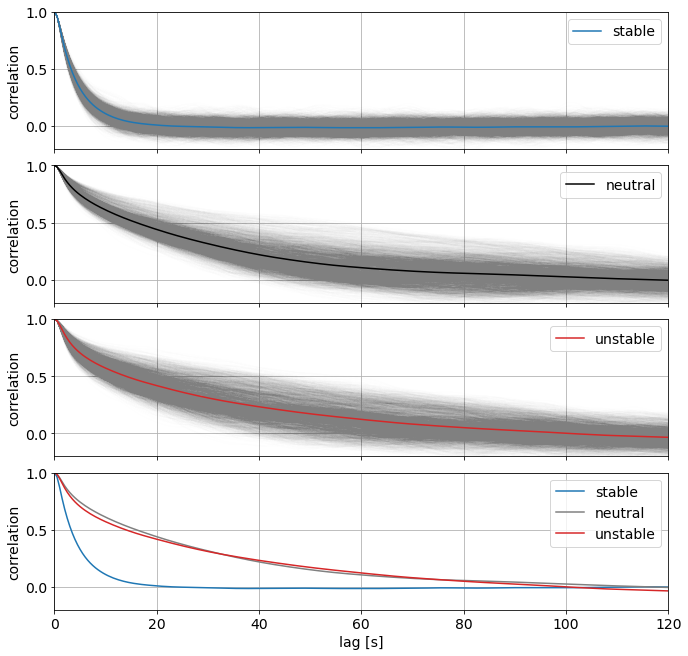

In [151]:
# old figure using small unstable case

In [152]:
# old statistics from plot above using small unstable case

State    |  Time scale [s]  | Length scale [m] 
-----------------------------------------------
Stable   |       4.61       |      36.87    
Neutral  |       24.92      |      199.39    
Unstable |       24.16      |      193.32    
